In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from torch_geometric.data import HeteroData
from typing import Dict, Optional
import pandas as pd

/opt/anaconda3/envs/aml2/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CrimeGraphVisualizer:
    """Visualize crime scene graphs with nodes and relationships."""
    
    def __init__(self):
        # Color scheme for different node types
        self.node_colors = {
            'person': '#FF6B6B',      # Red
            'object': '#4ECDC4',       # Teal
            'location': '#95E1D3'      # Light green
        }
        
        # Edge styles for different relationship types
        self.edge_colors = {
            'acts_on': '#E74C3C',      # Dark red
            'uses': '#3498DB',          # Blue
            'at': '#2ECC71'             # Green
        }
    
    def hetero_to_networkx(self, data: HeteroData, scene_df: pd.DataFrame) -> nx.MultiDiGraph:
        """Convert PyG HeteroData to NetworkX graph for visualization."""
        G = nx.MultiDiGraph()
        
        # Get entity names from the dataframe
        persons = list(pd.concat([scene_df['suspect'], scene_df['victim']]).unique())
        objects = list(scene_df['object'].unique())
        locations = list(scene_df['location'].unique())
        
        # Add nodes with types
        for i, person in enumerate(persons):
            G.add_node(f"person_{i}", label=person, node_type='person')
        for i, obj in enumerate(objects):
            G.add_node(f"object_{i}", label=obj, node_type='object')
        for i, loc in enumerate(locations):
            G.add_node(f"location_{i}", label=loc, node_type='location')
        
        # Create mappings
        person_to_idx = {p: i for i, p in enumerate(persons)}
        object_to_idx = {o: i for i, o in enumerate(objects)}
        location_to_idx = {l: i for i, l in enumerate(locations)}
        
        # Add edges from events
        for _, event in scene_df.iterrows():
            suspect_idx = person_to_idx[event['suspect']]
            victim_idx = person_to_idx[event['victim']]
            obj_idx = object_to_idx[event['object']]
            loc_idx = location_to_idx[event['location']]
            action = event['action']
            
            # Person -> Person (action)
            G.add_edge(f"person_{suspect_idx}", f"person_{victim_idx}",
                      label=action, edge_type='acts_on')
            
            # Person -> Object (uses)
            G.add_edge(f"person_{suspect_idx}", f"object_{obj_idx}",
                      label='uses', edge_type='uses')
            
            # Person -> Location (at)
            G.add_edge(f"person_{suspect_idx}", f"location_{loc_idx}",
                      label='at', edge_type='at')
            G.add_edge(f"person_{victim_idx}", f"location_{loc_idx}",
                      label='at', edge_type='at')
        
        return G
    
    def visualize(self, scene_df: pd.DataFrame, data: HeteroData = None,
                  title: str = "Crime Scene Graph", figsize: tuple = (14, 10),
                  save_path: Optional[str] = None):
        """
        Visualize a crime scene as a graph.
        
        Args:
            scene_df: DataFrame for a single crime scene
            data: Optional HeteroData object (will build from df if not provided)
            title: Plot title
            figsize: Figure size
            save_path: If provided, save figure to this path
        """
        G = self.hetero_to_networkx(data, scene_df)
        
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        
        # Use spring layout with more spacing
        pos = nx.spring_layout(G, k=3, iterations=50, seed=42)
        
        # Draw nodes by type
        for node_type, color in self.node_colors.items():
            nodes = [n for n, d in G.nodes(data=True) if d.get('node_type') == node_type]
            labels = {n: G.nodes[n]['label'] for n in nodes}
            
            nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=color,
                                   node_size=2000, alpha=0.9, ax=ax)
            nx.draw_networkx_labels(G, pos, labels=labels, font_size=9,
                                    font_weight='bold', ax=ax)
        
        # Draw edges with different colors and styles
        for edge_type, color in self.edge_colors.items():
            edges = [(u, v) for u, v, d in G.edges(data=True) 
                    if d.get('edge_type') == edge_type]
            
            if edges:
                nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=color,
                                       width=2, alpha=0.7, arrows=True,
                                       arrowsize=20, connectionstyle="arc3,rad=0.1",
                                       ax=ax)
        
        # Draw edge labels
        edge_labels = {}
        for u, v, d in G.edges(data=True):
            key = (u, v)
            if key in edge_labels:
                edge_labels[key] += f"\n{d['label']}"
            else:
                edge_labels[key] = d['label']
        
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,
                                     font_size=8, font_color='#333333', ax=ax)
        
        # Create legend
        legend_handles = []
        for node_type, color in self.node_colors.items():
            legend_handles.append(mpatches.Patch(color=color, label=f'{node_type.title()} Node'))
        for edge_type, color in self.edge_colors.items():
            legend_handles.append(mpatches.Patch(color=color, label=f'{edge_type} Edge'))
        
        ax.legend(handles=legend_handles, loc='upper left', fontsize=10)
        
        # Add scene info
        crime_type = scene_df['crime_type'].iloc[0]
        scene_id = scene_df['scene_id'].iloc[0]
        ax.set_title(f"{title}\nScene ID: {scene_id} | Crime Type: {crime_type}",
                    fontsize=14, fontweight='bold')
        
        ax.axis('off')
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"Graph saved to {save_path}")
        
        plt.show()
        
        return G
    
    def visualize_multiple(self, df: pd.DataFrame, scene_ids: list = None,
                           cols: int = 2, figsize_per_plot: tuple = (7, 5),
                           save_path: Optional[str] = None):
        """Visualize multiple crime scenes in a grid."""
        if scene_ids is None:
            scene_ids = df['scene_id'].unique()[:4]  # Default to first 4
        
        n_scenes = len(scene_ids)
        rows = (n_scenes + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, 
                                  figsize=(figsize_per_plot[0]*cols, figsize_per_plot[1]*rows))
        axes = axes.flatten() if n_scenes > 1 else [axes]
        
        for idx, scene_id in enumerate(scene_ids):
            scene_df = df[df['scene_id'] == scene_id]
            G = self.hetero_to_networkx(None, scene_df)
            
            ax = axes[idx]
            pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
            
            # Draw nodes
            for node_type, color in self.node_colors.items():
                nodes = [n for n, d in G.nodes(data=True) if d.get('node_type') == node_type]
                labels = {n: G.nodes[n]['label'] for n in nodes}
                nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=color,
                                       node_size=1000, alpha=0.9, ax=ax)
                nx.draw_networkx_labels(G, pos, labels=labels, font_size=7, ax=ax)
            
            # Draw edges
            for edge_type, color in self.edge_colors.items():
                edges = [(u, v) for u, v, d in G.edges(data=True) 
                        if d.get('edge_type') == edge_type]
                if edges:
                    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=color,
                                           width=1.5, alpha=0.7, arrows=True,
                                           arrowsize=15, ax=ax)
            
            crime_type = scene_df['crime_type'].iloc[0]
            ax.set_title(f"Scene {scene_id}: {crime_type}", fontsize=10, fontweight='bold')
            ax.axis('off')
        
        # Hide empty subplots
        for idx in range(n_scenes, len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        
        plt.show()


In [3]:
# ============================================================
# USAGE EXAMPLE
# ============================================================

def visualize_crime_graphs(df: pd.DataFrame):
    """Helper function to quickly visualize graphs from your data."""
    
    visualizer = CrimeGraphVisualizer()
    
    # Get available scenes
    scene_ids = df['scene_id'].unique()
    print(f"Available scenes: {scene_ids}")
    
    # Visualize first scene in detail
    first_scene_id = scene_ids[0]
    first_scene = df[df['scene_id'] == first_scene_id]
    
    print(f"\n--- Visualizing Scene {first_scene_id} ---")
    print(first_scene[['suspect', 'victim', 'object', 'action', 'location']].to_string())
    
    visualizer.visualize(first_scene, title="Crime Scene Graph")
    
    # Visualize multiple scenes in grid
    if len(scene_ids) > 1:
        print(f"\n--- Visualizing Multiple Scenes ---")
        visualizer.visualize_multiple(df, scene_ids=scene_ids[:4])
    
    return visualizer

Available scenes: [1 2 3]

--- Visualizing Scene 1 ---
  suspect victim object   action location
0    John  Maria  knife  stabbed     home
1    John  Maria  knife     fled     home


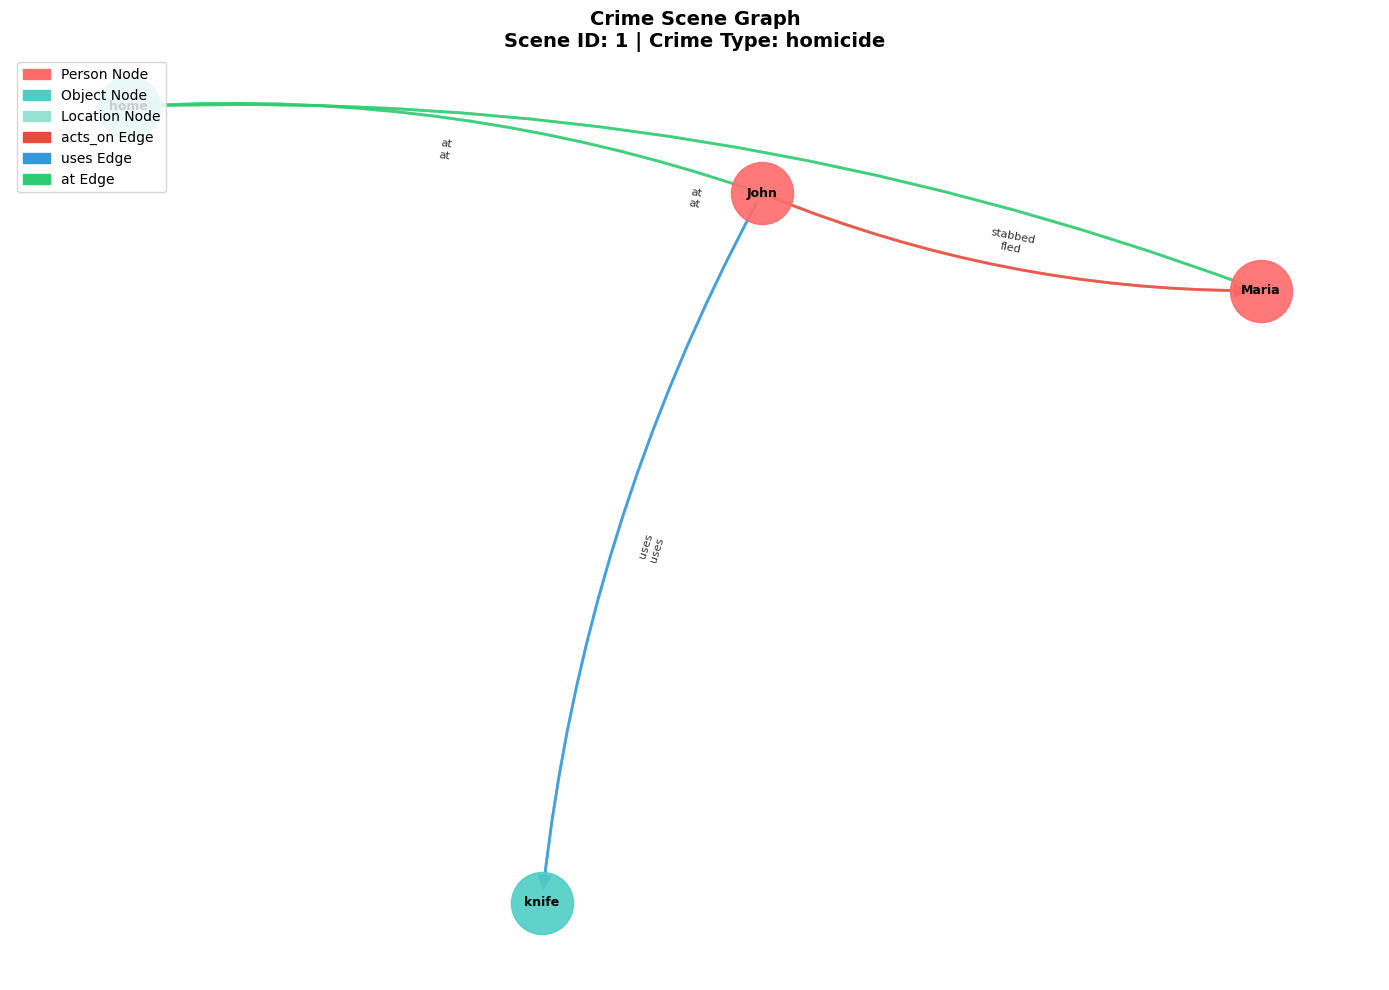


--- Visualizing Multiple Scenes ---


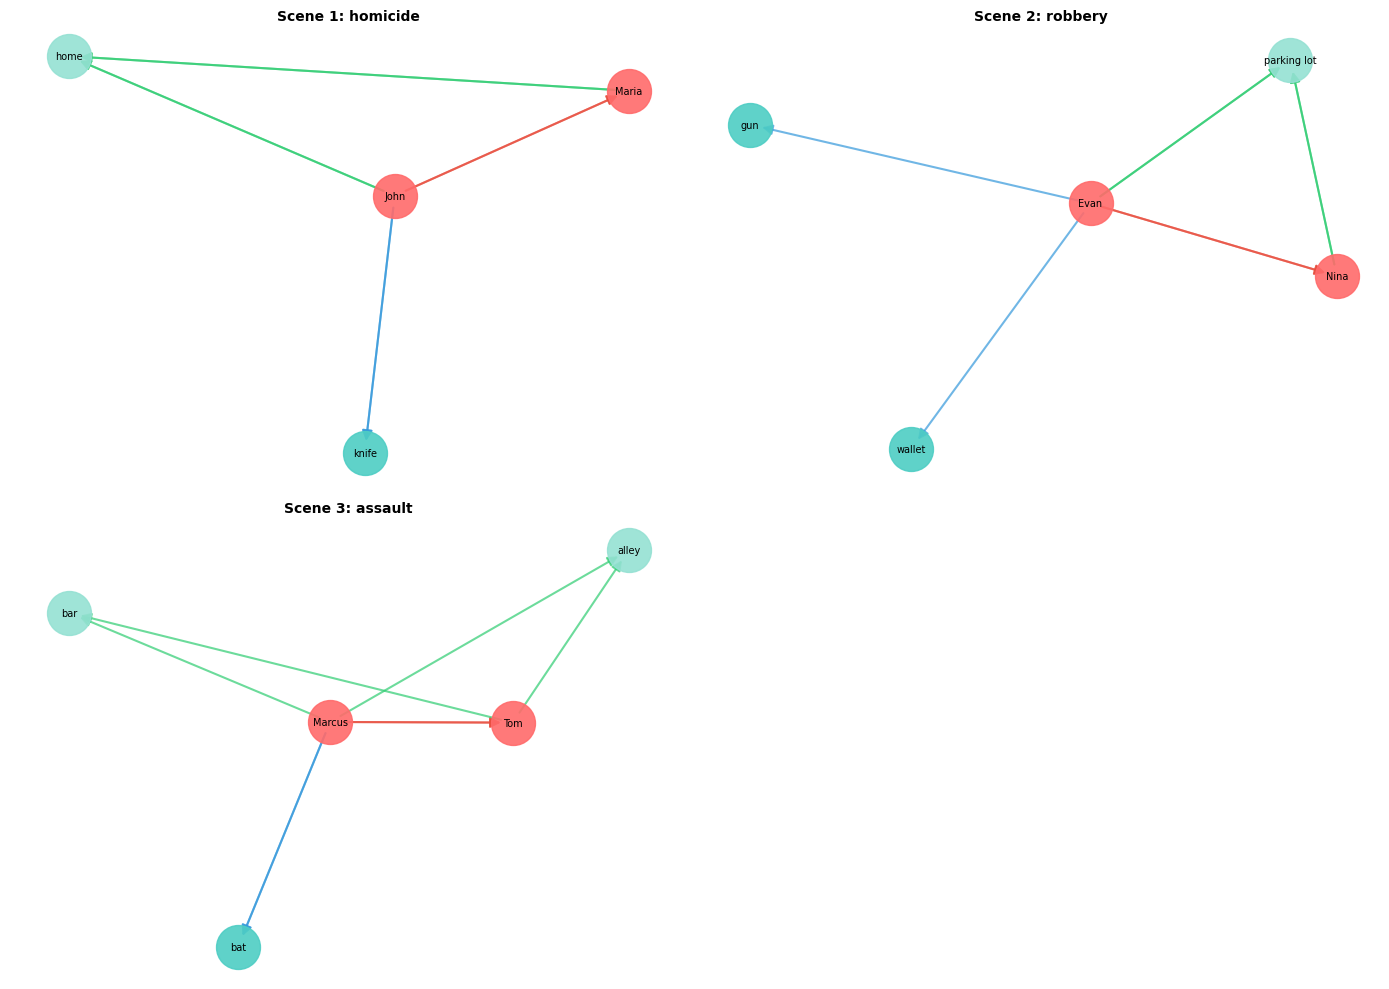

In [4]:
# Run if called directly
if __name__ == "__main__":
    # Sample data for testing
    data = {
        'scene_id': [1,1,2,2,3,3],
        'event_id': [1,2,1,2,1,2],
        'crime_type': ['homicide','homicide','robbery','robbery','assault','assault'],
        'suspect': ['John','John','Evan','Evan','Marcus','Marcus'],
        'victim': ['Maria','Maria','Nina','Nina','Tom','Tom'],
        'object': ['knife','knife','wallet','gun','bat','bat'],
        'location': ['home','home','parking lot','parking lot','bar','alley'],
        'action': ['stabbed','fled','threatened','robbed','attacked','fled'],
    }
    df = pd.DataFrame(data)
    
    visualize_crime_graphs(df)